# Deploying the model 

This is a separate inference script. We need to repeat the following steps:
- Creating custom datasets.
- Creating the model.
- Define the validation dataset and model.

In [1]:
import torchvision
torchvision.__version__

'0.5.0'

# Create Dataset 

In [3]:
import os
import pandas as pd
import matplotlib.pylab as plt
import torch
%matplotlib inline

In [4]:
def scale_label(a, b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

def rescale_label(a, b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

In [5]:
import torchvision.transforms.functional as TF

def resize_img_label(image, label=(0., 0.), target_size=(256, 256)):
    w_orig, h_orig = image.size
    w_target, h_target = target_size
    cx, cy = label
    
    # resize image and label
    image_new = TF.resize(image, target_size)
    label_new = cx/w_orig * w_target, cy/h_orig * h_target
    
    return image_new, label_new

In [6]:
def transformer(image, label, params):
    image, label = resize_img_label(image,
                                    label,
                                    params["target_size"])
    
    if params["scale_label"]:
        label = scale_label(label, params["target_size"])
        
    image = TF.to_tensor(image)
    return image, label

In [7]:
from torch.utils.data import Dataset
from PIL import Image

In [8]:
class AMD_dataset(Dataset):
    def __init__(self, path2data, transform, trans_params):
        pass
    
    def __len__(self):
        # return size of dataset
        return len(self.labels)
    
    def __getitem__(self, idx):
        pass

In [9]:
def __init__(self, path2data, transform, trans_params):
    # full path of the labels file
    path2labels = os.path.join(path2data, "Training400",
                               "Fovea_location.xlsx")
    
    # read labels as a data frame
    labels_df = pd.read_excel(path2labels, index_col="ID")
    
    # extract labels
    self.labels = labels_df[["Fovea_X", "Fovea_Y"]].values
    
    # extract ID and imgName columns
    self.imgName = labels_df["imgName"]
    self.ids = labels_df.index
    
    self.fullPath2img = [0] * len(self.ids)
    
    for id_ in self.ids:
        if self.imgName[id_][0] == "A":
            prefix = "AMD"
        else:
            prefix = "Non-AMD"
        
        self.fullPath2img[id_-1] = os.path.join(path2data,
                                                "Training400",
                                                prefix,
                                                self.imgName[id_])
    
    self.transform = transform
    self.trans_params = trans_params

In [10]:
def __getitem__(self, idx):
    # load PIL image
    image = Image.open(self.fullPath2img[idx])
    label = self.labels[idx]
    
    # transform to tensor
    image, label = self.transform(image, label, self.trans_params)
    
    return image, label

In [11]:
AMD_dataset.__init__=__init__
AMD_dataset.__getitem__=__getitem__

In [12]:
path2data = "./data/"

trans_params_val = {
    "target_size": (256, 256),
    "p_hflip": 0.0,
    "p_vflip": 0.0,
    "p_shift": 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "gamma": 0.0,
    "scale_label": True,
}

amd_ds2 = AMD_dataset(path2data, transformer, trans_params_val)

In [13]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = range(len(amd_ds2))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

319
----------
80


In [14]:
from torch.utils.data import Subset
val_ds = Subset(amd_ds2, val_index)
print(len(val_ds))

80


# Data Loaders

In [15]:
from torch.utils.data import DataLoader
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

# Building Model

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        
    def forward(self, x):
        return x

In [18]:
def __init__(self, params):
    super(Net, self).__init__()
    
    c_in, h_in, w_in = params["input_shape"]
    init_f = params["initial_filters"]
    num_outputs = params["num_outputs"]
    
    self.conv1 = nn.Conv2d(c_in, init_f, kernel_size=3, stride=2,
                           padding=1)
    self.conv2 = nn.Conv2d(init_f + c_in, 2 * init_f, kernel_size=3,
                           padding=1)
    self.conv3 = nn.Conv2d(3 * init_f + c_in, 4 * init_f,
                           kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(7 * init_f + c_in, 8 * init_f,
                           kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(15 * init_f + c_in, 16 * init_f,
                           kernel_size=3, padding=1)
    
    self.fc1 = nn.Linear(16 * init_f, num_outputs)

In [19]:
def forward(self, x):
    identity = F.avg_pool2d(x, 4, 4)
    
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity = F.avg_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity = F.avg_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity = F.avg_pool2d(x, 2, 2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    x = F.relu(self.conv5(x))
    
    x = F.adaptive_avg_pool2d(x, 1)
    x = x.reshape(x.size(0), -1)
    
    x = self.fc1(x)
    return x

In [20]:
Net.__init__=__init__
Net.forward=forward

In [21]:
params_model = {
    "input_shape": (3, 256, 256),
    "initial_filters": 16,
    "num_outputs": 2,
}

# create model
model = Net(params_model)
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [22]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)

# Deployment

## Load weights

In [23]:
path2weights = "./models/weights_smoothl1.pt"
model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [24]:
# define device as a global variable
device = torch.device("cuda")

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        # convert to tensor
        yb = torch.stack(yb, 1)
        yb = yb.type(torch.float32).to(device)
        
        # get model output
        output = model(xb.to(device))
        
        # get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss += loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric += metric_b
        
        # break the loop for sanity check
        if sanity_check is True:
            break
            
    # average loss value
    loss = running_loss/float(len_data)
    
    # average metric value
    metric = running_metric/float(len_data)
    
    return loss, metric

In [25]:
def cxcy2bbox(cxcy, w=50./256, h=50./256):
    # define two new tensors for w and h
    w_tensor = torch.ones(cxcy.shape[0], 1, device=cxcy.device) * w
    h_tensor = torch.ones(cxcy.shape[0], 1, device=cxcy.device) * h
    
    # extract cx and cy
    cx = cxcy[:, 0].unsqueeze(1)
    cy = cxcy[:, 1].unsqueeze(1)
    
    # concat cx, cy, w and h
    boxes = torch.cat((cx, cy, w_tensor, h_tensor), -1)
    
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,
                     boxes[:, :2] + boxes[:, 2:]), 1)

In [26]:
def metrics_batch(output, target):
    output = cxcy2bbox(output)
    target = cxcy2bbox(target)
    
    iou = torchvision.ops.box_iou(output, target)
    
    return torch.diagonal(iou, 0).sum().item()

In [27]:
def loss_batch(loss_func, output, target, opt=None):
    # get loss
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b

## Verify

In [28]:
loss_func = nn.SmoothL1Loss(reduction="sum")

with torch.no_grad():
    loss, metric = loss_epoch(model, loss_func, val_dl)

print(loss, metric)

0.004274576576426626 0.7385008215904236


In [29]:
from PIL import ImageDraw
import numpy as np
import torchvision.transforms.functional as tv_F
np.random.seed(0)

import matplotlib.pylab as plt
%matplotlib inline

In [30]:
def show_tensor_2labels(img, label1, label2, w_h=(50, 50)):
    label1 = rescale_label(label1, img.shape[1:])
    label2 = rescale_label(label2, img.shape[1:])
    
    img = tv_F.to_pil_image(img)
    
    w, h = w_h
    cx, cy = label1
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),
                   outline="green", width=2)
    
    cx, cy = label2
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),
                   outline="red", width=2)
    
    plt.imshow(np.asarray(img))

In [31]:
# get random samples
rndInds = np.random.randint(len(val_ds), size=10)
print(rndInds)

[44 47 64 67 67  9 21 36 70 12]


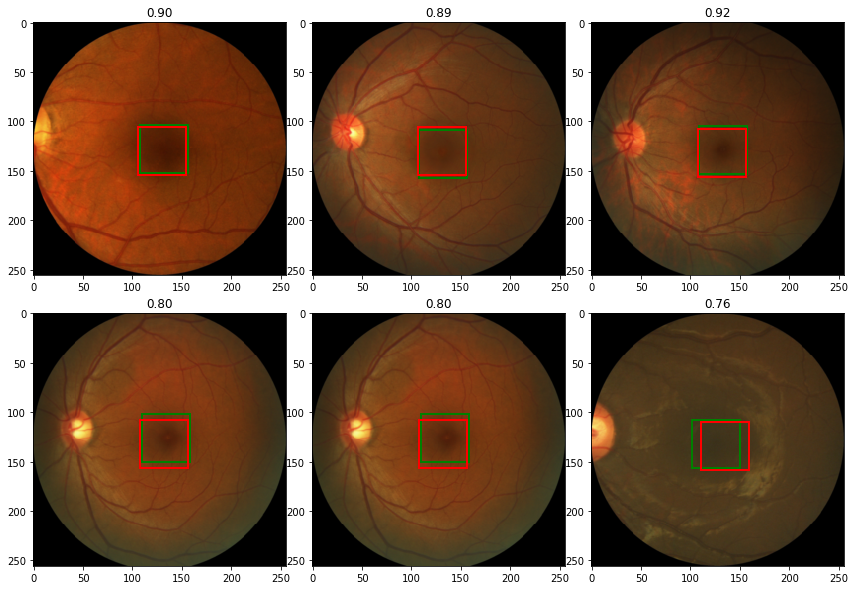

In [33]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplots_adjust(wspace=0.0, hspace=0.15)

for i, rndi in enumerate(rndInds):
    img, label = val_ds[rndi]
    h, w = img.shape[1:]
    
    with torch.no_grad():
        label_pred = model(img.unsqueeze(0).to(device))[0].cpu()
        
    plt.subplot(2, 3, i+1)
    show_tensor_2labels(img, label, label_pred)
    
    # calculate IOU
    label_bb = cxcy2bbox(torch.tensor(label).unsqueeze(0))
    label_pred_bb = cxcy2bbox(label_pred.unsqueeze(0))
    iou = torchvision.ops.box_iou(label_bb, label_pred_bb)
    plt.title("%.2f" %iou.item())
    
    if i>4:
        break

In [34]:
def load_img_label(labels_df, id_):
    imgName = labels_df ["imgName"]
    
    if imgName[id_][0] == "A":
        prefix = "AMD"
    else:
        prefix = "Non-AMD"
        
    fullPath2img = os.path.join(path2data, "Training400",
                                prefix, imgName[id_])
    img = Image.open(fullPath2img)
    
    # centroid
    x = labels_df["Fovea_X"][id_]
    y = labels_df["Fovea_Y"][id_]
    
    label = (x, y)
    
    return img, label

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)
torch.Size([3, 256, 256])


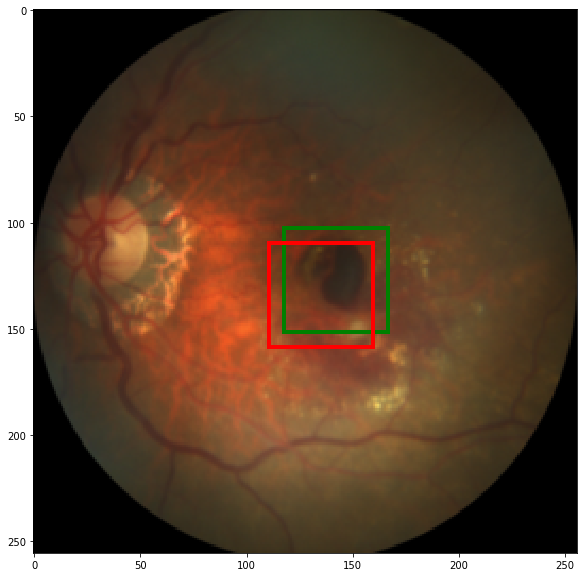

In [35]:
path2labels = os.path.join(path2data, "Training400",
                           "Fovea_location.xlsx")
labels_df = pd.read_excel(path2labels, index_col="ID")

img, label = load_img_label(labels_df, 1)
print(img.size, label)

img, label = resize_img_label(img, label, target_size=(256, 256))
print(img.size, label)

img = TF.to_tensor(img)
label = scale_label(label, (256, 256))
print(img.shape)

with torch.no_grad():
    label_pred = model(img.unsqueeze(0).to(device))[0].cpu()
    
show_tensor_2labels(img, label, label_pred)

In [36]:
import time

elapsed_times = []

with torch.no_grad():
    for k in range(100):
        start = time.time()
        label_pred = model(img.unsqueeze(0).to(device))[0].cpu()
        elapsed = time.time() - start
        elapsed_times.append(elapsed)

print("inference time per image: %.4f s" %np.mean(elapsed_times))

inference time per image: 0.0010 s
